<a href="https://colab.research.google.com/github/srJboca/segmentacion/blob/main/EN/3.%20Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Gas Customer Segmentation

## Introduction

This notebook focuses on customer segmentation using the `df_analisis.parquet` DataFrame, which was prepared in the data exploration notebook. Customer segmentation allows us to group customers with similar characteristics, which is useful for personalized marketing strategies, service management, and operational optimization.

**Objective:** Identify distinct customer segments based on their consumption and payment behavior.

**Techniques Used:**
1.  **Data Aggregation:** Transforming invoice-level data into customer-level features.
2.  **Principal Component Analysis (PCA):** Reducing the dimensionality of the data to facilitate visualization and clustering.
3.  **K-Means Clustering:** Grouping customers into K distinct segments.
4.  **Segment Profiling:** Analyzing the characteristics of each segment.

## 1. Environment Setup and Data Loading

### 1.1 Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

### 1.2 Downloading and Loading the Preprocessed DataFrame

We will use the `df_analisis.parquet` file.

In [2]:
!wget -N https://github.com/srJboca/segmentacion/raw/refs/heads/main/archivos/df_analisis.parquet
df_analysis = pd.read_parquet('df_analisis.parquet')

--2025-06-13 14:08:31--  https://github.com/srJboca/segmentacion/raw/refs/heads/main/archivos/df_analisis.parquet
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/srJboca/segmentacion/refs/heads/main/archivos/df_analisis.parquet [following]
--2025-06-13 14:08:31--  https://raw.githubusercontent.com/srJboca/segmentacion/refs/heads/main/archivos/df_analisis.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75105565 (72M) [application/octet-stream]
Saving to: ‘df_analisis.parquet’

df_analisis.parquet 100%[===================>]  71.63M  83.9MB/s    in 0.9s    

Last-modified header missing -- 

## 2. Quick Data Review
Let's recall the structure of the `df_analysis` DataFrame.

In [3]:
print("--- First 5 rows of df_analysis ---")
print(df_analysis.head())
print("\n--- Information of df_analysis ---")
df_analysis.info()

--- First 5 rows of df_analysis ---
                      Numero de factura                    Numero de contrato  \
0  886199bb-77c8-43e2-86a0-a53348fa2706  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
1  886199bb-77c8-43e2-86a0-a53348fa2706  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
2  6848b692-4212-4738-a35c-1f8c0d383e3d  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
3  ad91361e-9b8d-491e-bef9-e690e9b28faf  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
4  e77f7ac6-734b-4856-a5c3-1a32d845e6b6  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   

  Fecha de Emision  Consumo (m3) Fecha de Pago Oportuno Fecha de Lectura  \
0       2021-01-06         11.51             2021-01-19       2020-12-28   
1       2021-01-06         11.51             2021-01-19       2020-12-28   
2       2021-03-02         10.26             2021-03-17       2021-02-20   
3       2021-04-01         14.96             2021-04-11       2021-03-27   
4       2021-05-10         14.89             2021-05-21       2021-05-05   

  Fecha de Suspensio

## 3. Aggregating Features at the Customer Level

To segment customers, we need features that describe each customer's behavior over time. We will group the data by `Numero de contrato` and calculate aggregate metrics (averages) of their consumption, costs, and payment behavior.

In [4]:
df_grouped = df_analysis.groupby('Numero de contrato').agg(
    Average_Consumption=('Consumo (m3)', 'mean'),
    Average_Consumption_Price=('Precio por Consumo', 'mean'),
    Average_Days_Issue_DueDate=('Dias_Emision_PagoOportuno', 'mean'),
    Average_Days_Reading_Issue=('Dias_Lectura_Emision', 'mean'),
    Average_Days_DueDate_ActualPayment=('Dias_PagoOportuno_PagoReal', 'mean'),
    Average_Late_Payment_Rate=('Mora', 'mean') # Late payment rate
).reset_index()

print("--- df_grouped (data aggregated by customer) ---")
print(df_grouped.head())

--- df_grouped (data aggregated by customer) ---
                     Numero de contrato  Average_Consumption  \
0  0002515b-27eb-4ed0-aeda-800b97757408            12.979375   
1  00031ba9-1077-41e5-9fa4-2cc1264c4120            12.043958   
2  00059def-f6c3-4bcd-9ef0-ddc0b5b98e7c            12.331250   
3  00065e0e-9e76-4553-93d4-d95657449c2a            11.794375   
4  00077b9d-e09e-4da6-a201-38621c36bc28            12.132708   

   Average_Consumption_Price  Average_Days_Issue_DueDate  \
0               14186.484167                   12.645833   
1               13466.111667                   12.666667   
2               13503.808125                   12.541667   
3               15994.017708                   12.979167   
4               16402.697708                   12.375000   

   Average_Days_Reading_Issue  Average_Days_DueDate_ActualPayment  \
0                    7.041667                           -1.500000   
1                    7.166667                           -0.354167  

### 3.1 Incorporating 'Estrato Socioeconómico'

The 'Estrato socioeconomico' is an important customer characteristic. We will join it to the grouped DataFrame. We need to get the stratum from `df_analysis`. Since `df_analysis` already has the 'Estrato' column, we will use it, making sure to take a single value per customer.

In [5]:
# Get the stratum for each contract (taking the first one, assuming it doesn't change)
df_strata = df_analysis.drop_duplicates(subset=['Numero de contrato'])[['Numero de contrato', 'Estrato']].copy()
# Rename 'Estrato' to 'Estrato socioeconomico' for clarity
df_strata.rename(columns={'Estrato': 'Estrato socioeconomico'}, inplace=True)

df_segmentation = pd.merge(df_grouped, df_strata, on='Numero de contrato', how='left')

print("--- df_segmentation with Estrato ---")
print(df_segmentation.head())
print("\n--- Information about df_segmentation ---")
df_segmentation.info()

--- df_segmentation with Estrato ---
                     Numero de contrato  Average_Consumption  \
0  0002515b-27eb-4ed0-aeda-800b97757408            12.979375   
1  00031ba9-1077-41e5-9fa4-2cc1264c4120            12.043958   
2  00059def-f6c3-4bcd-9ef0-ddc0b5b98e7c            12.331250   
3  00065e0e-9e76-4553-93d4-d95657449c2a            11.794375   
4  00077b9d-e09e-4da6-a201-38621c36bc28            12.132708   

   Average_Consumption_Price  Average_Days_Issue_DueDate  \
0               14186.484167                   12.645833   
1               13466.111667                   12.666667   
2               13503.808125                   12.541667   
3               15994.017708                   12.979167   
4               16402.697708                   12.375000   

   Average_Days_Reading_Issue  Average_Days_DueDate_ActualPayment  \
0                    7.041667                           -1.500000   
1                    7.166667                           -0.354167   
2         

## 4. Preprocessing for PCA and Clustering

### 4.1 Selecting Numerical Features and Handling NaNs
We will select the numerical features for PCA and clustering. The 'Estrato socioeconomico' column is categorical, and we will handle it later or use it to profile the segments. For now, we will convert it to a numerical type since it's an ordinal feature.
We will also remove rows with NaN values in the selected features.

In [6]:
# Convert 'Estrato socioeconomico' to numeric (ordinal)
if df_segmentation['Estrato socioeconomico'].dtype == 'object' or isinstance(df_segmentation['Estrato socioeconomico'].dtype, pd.CategoricalDtype):
    df_segmentation['Stratum_Num'] = df_segmentation['Estrato socioeconomico'].str.replace('Estrato ', '', regex=False).astype(int)
else:
    df_segmentation['Stratum_Num'] = df_segmentation['Estrato socioeconomico'].astype(int)

features_for_pca = [
    'Average_Consumption',
    'Average_Consumption_Price',
    'Average_Days_Issue_DueDate',
    'Average_Days_Reading_Issue',
    'Average_Days_DueDate_ActualPayment',
    'Average_Late_Payment_Rate',
    'Stratum_Num' # We include the numerical stratum
]
X = df_segmentation[features_for_pca].copy()

print(f"Shape before dropna: {X.shape}")
X.dropna(inplace=True) # Remove rows with NaNs in these features
print(f"Shape after dropna: {X.shape}")

print("\nMissing values after dropna:")
print(X.isnull().sum())

Shape before dropna: (50000, 7)
Shape after dropna: (50000, 7)

Missing values after dropna:
Average_Consumption                   0
Average_Consumption_Price             0
Average_Days_Issue_DueDate            0
Average_Days_Reading_Issue            0
Average_Days_DueDate_ActualPayment    0
Average_Late_Payment_Rate             0
Stratum_Num                           0
dtype: int64


### 4.2 Feature Scaling
PCA is sensitive to the scale of the features. Therefore, we will standardize the data.

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("--- Scaled data (first 5 rows) ---")
print(pd.DataFrame(X_scaled, columns=X.columns).head())

--- Scaled data (first 5 rows) ---
   Average_Consumption  Average_Consumption_Price  Average_Days_Issue_DueDate  \
0             0.732802                  -0.486200                    0.576942   
1            -0.699988                  -0.662735                    0.658225   
2            -0.259940                  -0.653497                    0.170532   
3            -1.082279                  -0.043244                    1.877457   
4            -0.564049                   0.056908                   -0.479726   

   Average_Days_Reading_Issue  Average_Days_DueDate_ActualPayment  \
0                   -1.784536                           -2.015522   
1                   -1.296144                           -1.093100   
2                   -0.400760                           -0.489332   
3                    0.087632                            0.617574   
4                    0.576024                            0.399547   

   Average_Late_Payment_Rate  Stratum_Num  
0                  

## 5. Principal Component Analysis (PCA)

We will reduce the dimensionality to 2 principal components for visualization.

In [8]:
pca = PCA(n_components=2) # Reduce to 2 components
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(data=X_pca, columns=['principal_component_1', 'principal_component_2'])

print("--- Principal Components (first 5 rows) ---")
print(df_pca.head())

print(f"\nExplained variance by each component: {pca.explained_variance_ratio_}")
print(f"Total explained variance (2 components): {pca.explained_variance_ratio_.sum():.2f}")

--- Principal Components (first 5 rows) ---
   principal_component_1  principal_component_2
0              -0.896595              -2.373121
1              -0.686935              -1.710830
2              -1.316098               0.026509
3               0.102506               1.128067
4               0.264357               0.969185

Explained variance by each component: [0.27494557 0.24993022]
Total explained variance (2 components): 0.52


The total explained variance tells us what percentage of the original information is retained in the 2 principal components.

## 6. K-Means Clustering

### 6.1 Elbow Method for Optimal K
We will use the elbow method to help determine an appropriate number of clusters (K). We are looking for the point where adding more clusters does not significantly improve the Within-Cluster Sum of Squares (WCSS) or inertia.

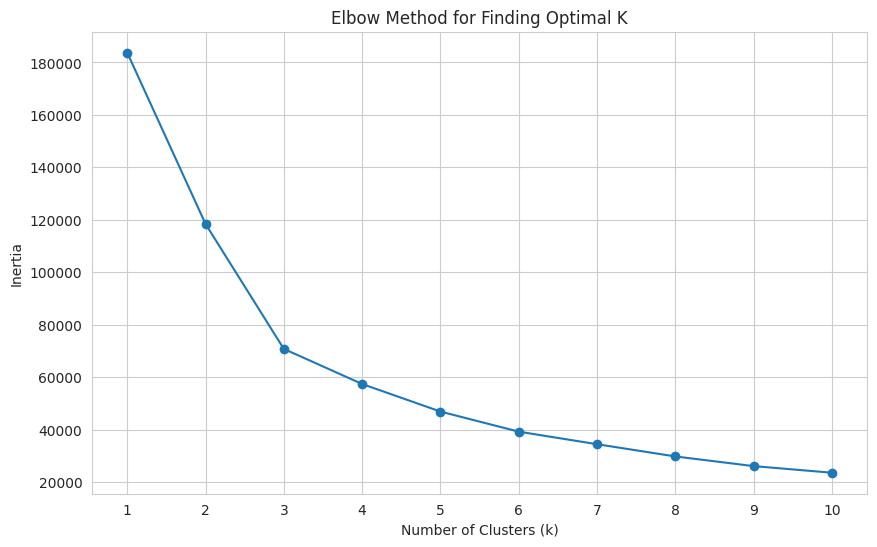

In [9]:
inertia_list = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto') # n_init='auto' is the default in recent versions
    kmeans.fit(df_pca) # We use the PCA-transformed data
    inertia_list.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_list, marker='o')
plt.title('Elbow Method for Finding Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

Observe the plot above. The "elbow" is the point where the rate of decrease in inertia flattens. This point suggests an optimal K value. For this tutorial, we will use K=4.


### 6.2 Applying K-Means and Visualization
We apply K-Means with the chosen K (K=4) and visualize the clusters in the PCA space.

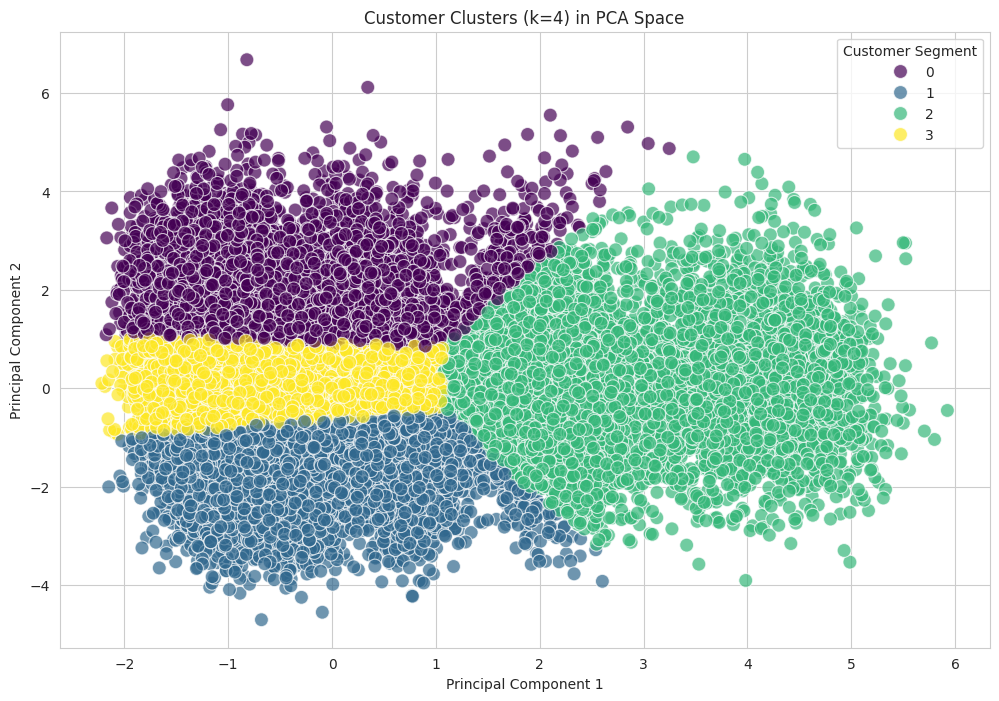

--- df_pca with Segments ---
   principal_component_1  principal_component_2  segment
0              -0.896595              -2.373121        1
1              -0.686935              -1.710830        1
2              -1.316098               0.026509        3
3               0.102506               1.128067        0
4               0.264357               0.969185        0


In [10]:
optimal_k = 4 # @param {type:"integer"} # Chosen from the elbow method or business analysis

kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
df_pca['segment'] = kmeans_optimal.fit_predict(df_pca)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='principal_component_1', y='principal_component_2', hue='segment', data=df_pca, palette='viridis', s=100, alpha=0.7)
plt.title(f'Customer Clusters (k={optimal_k}) in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Customer Segment')
plt.grid(True)
plt.show()

print("--- df_pca with Segments ---")
print(df_pca.head())

## 7. Segment Profiling

Now that we have the segments, we need to understand what characterizes each one. We will join the segment labels back to the `df_segmentation` DataFrame (which contains the aggregated features and the stratum) and analyze the mean of the features for each segment.

In [11]:
# Since X was created from X.dropna(), df_pca should have the same length and order
# We create df_segmentation_cleaned to ensure the index correspondence
df_segmentation_cleaned = df_segmentation.loc[X.index].copy()
df_segmentation_cleaned['segment'] = df_pca['segment'].values

print("--- df_segmentation_cleaned with Segments ---")
print(df_segmentation_cleaned.head())

--- df_segmentation_cleaned with Segments ---
                     Numero de contrato  Average_Consumption  \
0  0002515b-27eb-4ed0-aeda-800b97757408            12.979375   
1  00031ba9-1077-41e5-9fa4-2cc1264c4120            12.043958   
2  00059def-f6c3-4bcd-9ef0-ddc0b5b98e7c            12.331250   
3  00065e0e-9e76-4553-93d4-d95657449c2a            11.794375   
4  00077b9d-e09e-4da6-a201-38621c36bc28            12.132708   

   Average_Consumption_Price  Average_Days_Issue_DueDate  \
0               14186.484167                   12.645833   
1               13466.111667                   12.666667   
2               13503.808125                   12.541667   
3               15994.017708                   12.979167   
4               16402.697708                   12.375000   

   Average_Days_Reading_Issue  Average_Days_DueDate_ActualPayment  \
0                    7.041667                           -1.500000   
1                    7.166667                           -0.354167   
2

### 7.1 Average Characteristics per Segment

--- Segment Profiles (Average Characteristics) ---
         Average_Consumption  Average_Consumption_Price  \
segment                                                   
0                  12.507878               15029.937120   
1                  12.504786               14835.776436   
2                  12.573909               24653.506021   
3                  12.467332               14490.595034   

         Average_Days_Issue_DueDate  Average_Days_Reading_Issue  \
segment                                                           
0                         12.498508                    7.496459   
1                         12.497406                    7.502133   
2                         12.495209                    7.498953   
3                         12.499094                    7.496600   

         Average_Days_DueDate_ActualPayment  Average_Late_Payment_Rate  \
segment                                                                  
0                                  2.622968

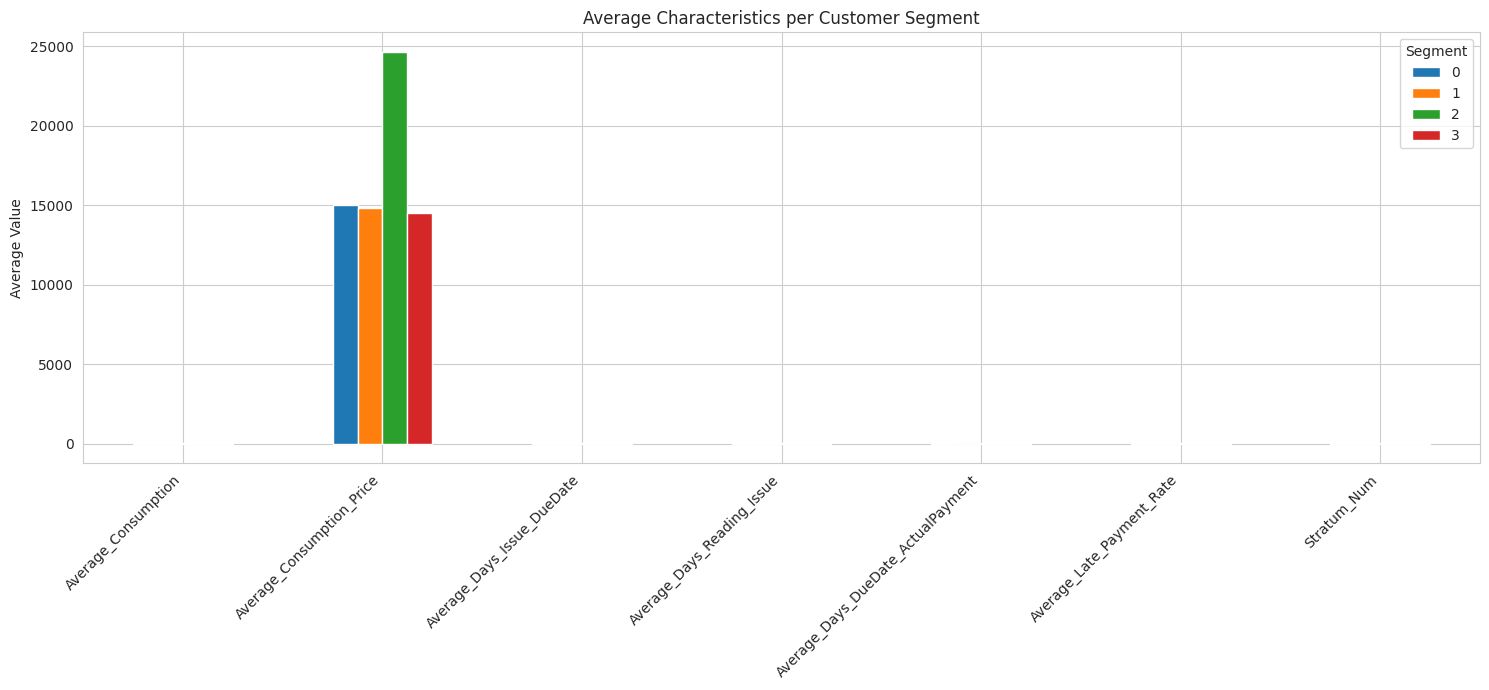

In [12]:
segment_profiles = df_segmentation_cleaned.groupby('segment')[features_for_pca].mean()
print("--- Segment Profiles (Average Characteristics) ---")
print(segment_profiles)

# Visualizing the profiles
segment_profiles.T.plot(kind='bar', figsize=(15, 7))
plt.title('Average Characteristics per Customer Segment')
plt.ylabel('Average Value')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Segment')
plt.tight_layout()
plt.show()

### 7.2 Stratum Distribution per Segment


--- Percentage Distribution of Stratum per Segment ---
Estrato socioeconomico  Estrato 1  Estrato 2  Estrato 3  Estrato 4  Estrato 5  \
segment                                                                         
0                       26.305140  38.617968  32.335087   2.701335   0.040469   
1                       26.920220  40.551181  31.525776   1.002823   0.000000   
2                        0.000000   0.000000   2.993272  63.256900  17.163257   
3                       31.996283  42.894017  25.094213   0.015487   0.000000   

Estrato socioeconomico  Estrato 6  
segment                            
0                        0.000000  
1                        0.000000  
2                       16.586571  
3                        0.000000  


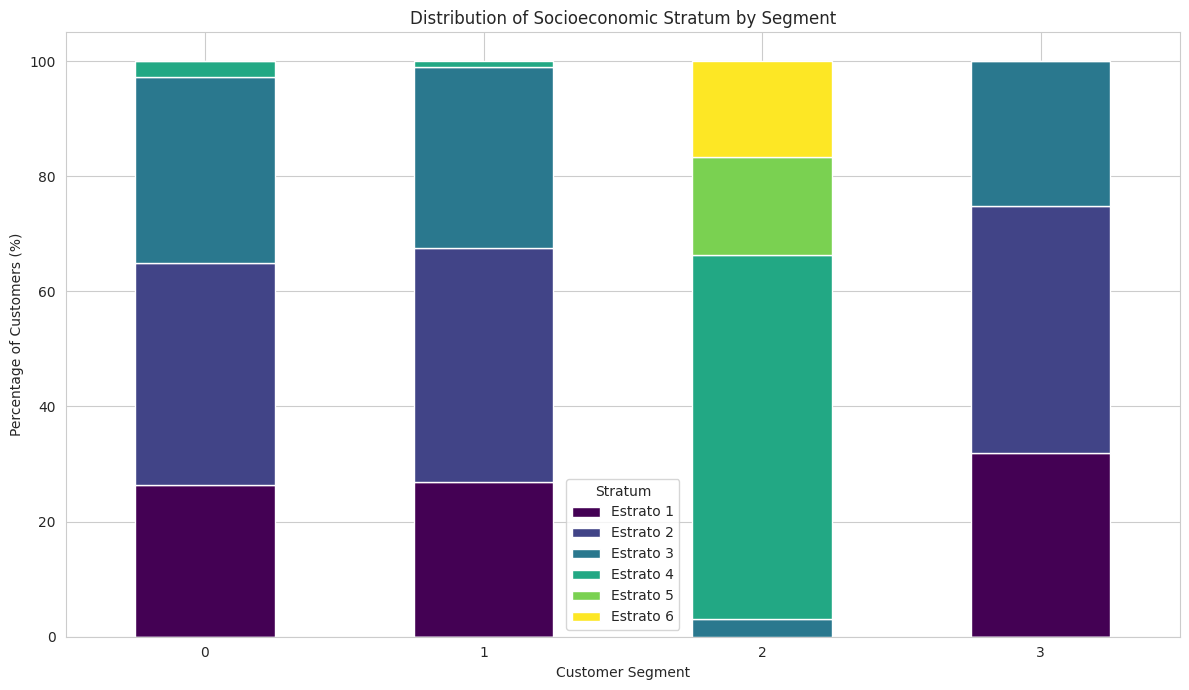

In [13]:
stratum_segment_distribution = pd.crosstab(df_segmentation_cleaned['segment'], df_segmentation_cleaned['Estrato socioeconomico'], normalize='index') * 100
print("\n--- Percentage Distribution of Stratum per Segment ---")
print(stratum_segment_distribution)

stratum_segment_distribution.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis')
plt.title('Distribution of Socioeconomic Stratum by Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Percentage of Customers (%)')
plt.xticks(rotation=0)
plt.legend(title='Stratum')
plt.tight_layout()
plt.show()

**Interpreting the Profiles:**
* **Average Characteristics:** Look at the bars for each segment. Which characteristics have high or low values in a particular segment? For example, one segment might have a high 'Average_Consumption' and a low 'Average_Late_Payment_Rate', indicating high-value customers with good payment behavior.
* **Stratum Distribution:** Is there a predominant stratum in each segment? This can help understand the socioeconomic composition of the groups.

**Naming the Segments (Example):**
Based on the analysis, you could assign descriptive names to each segment, such as:
* **Segment 0:** Low Consumption, Punctual Payers
* **Segment 1:** High Consumption, Moderate Late Payments, High Stratum
* Etc.

## 8. Conclusions and Next Steps

In this notebook, we have:
1.  Aggregated data at the customer level.
2.  Used PCA to reduce dimensionality and facilitate visualization.
3.  Applied K-Means to group customers into segments (K=4 in this example).
4.  Begun profiling the segments by analyzing their average characteristics and stratum distribution.

**Potential Next Steps:**
* **Segment Validation:** Use clustering metrics (like the Silhouette Coefficient) to evaluate the quality of the segments. Also, validate the stability of the segments with different K-Means initializations or data subsets.
* **Detailed Profiling:** Analyze more variables for each segment (e.g., customer tenure, contract type, if they were included).
* **Strategic Actions:** Define specific strategies for each segment (e.g., loyalty campaigns for high-value customers, late payment management programs for segments with high default rates, personalized offers based on consumption).
* **Monitoring:** Observe how segments evolve over time and whether customers move from one segment to another.
* **Try other algorithms:** Explore other clustering algorithms (e.g., DBSCAN, Agglomerative Clustering) if K-Means does not produce satisfactory results or if non-spherical cluster structures are suspected.

Customer segmentation is a powerful tool for better understanding the customer base and making more informed business decisions.